In [340]:
import pandas as pd
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time
from datetime import datetime

warnings.filterwarnings('ignore')

#模型预测
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor


#降维
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb
from lightgbm.sklearn import LGBMRegressor

#评价
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.metrics import mean_absolute_error,make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [278]:
path = 'D:/data analysis/天池-二手车/'
train_data = pd.read_csv(path+'used_car_train_20200313.csv',sep=' ')
test_data = pd.read_csv(path+'used_car_testB_20200421.csv',sep= ' ')

In [280]:
train_data.shape

(150000, 31)

In [281]:
test_data.shape

(50000, 30)

In [282]:
all_data = pd.concat([train_data,test_data],ignore_index=True)
all_data.shape

(200000, 31)

In [283]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             200000 non-null  int64  
 1   name               200000 non-null  int64  
 2   regDate            200000 non-null  int64  
 3   model              199999 non-null  float64
 4   brand              200000 non-null  int64  
 5   bodyType           193990 non-null  float64
 6   fuelType           188396 non-null  float64
 7   gearbox            192051 non-null  float64
 8   power              200000 non-null  int64  
 9   kilometer          200000 non-null  float64
 10  notRepairedDamage  200000 non-null  object 
 11  regionCode         200000 non-null  int64  
 12  seller             200000 non-null  int64  
 13  offerType          200000 non-null  int64  
 14  creatDate          200000 non-null  int64  
 15  price              150000 non-null  float64
 16  v_

In [284]:
all_data.isnull().sum()

SaleID                   0
name                     0
regDate                  0
model                    1
brand                    0
bodyType              6010
fuelType             11604
gearbox               7949
power                    0
kilometer                0
notRepairedDamage        0
regionCode               0
seller                   0
offerType                0
creatDate                0
price                50000
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
dtype: int64

In [285]:
cat_fea = ['name','regDate','model','brand','bodyType','fuelType','gearbox','kilometer'
          ,'notRepairedDamage','regionCode','seller','offerType','creatDate']

In [289]:
for fea in cat_fea:
    print('{}特征有{}个不同的值'.format(fea,all_data[fea].nunique()))
    print(all_data[fea].value_counts())

name特征有128660个不同的值
387      376
55       373
708      367
1541     349
203      311
        ... 
45755      1
47802      1
53943      1
55990      1
4094       1
Name: name, Length: 128660, dtype: int64
regDate特征有3898个不同的值
20000008    235
20000011    213
20000002    211
20000009    206
20000001    205
           ... 
19910807      1
20151209      1
19910909      1
19910801      1
20151201      1
Name: regDate, Length: 3898, dtype: int64
model特征有248个不同的值
0.0      15534
19.0     12799
4.0      11235
1.0       8019
29.0      6964
         ...  
243.0        4
244.0        4
242.0        3
240.0        2
247.0        1
Name: model, Length: 248, dtype: int64
brand特征有40个不同的值
0     41953
4     22269
14    21434
10    18962
1     18421
6     13717
9      9666
5      6150
13     5203
11     3887
3      3281
7      3088
16     2993
25     2792
8      2785
27     2676
21     2090
15     1934
19     1861
20     1647
12     1508
22     1443
26     1294
30     1261
17     1225
24     1020
28      86

In [294]:
all_data['name_count'] = all_data.groupby(['name'])['SaleID'].transform('count')

In [297]:
del all_data['name']

In [304]:
all_data.drop(all_data[all_data['seller'] == 1].index,inplace=True)

In [305]:
all_data.shape

(199999, 31)

In [306]:
del all_data['offerType']
del all_data['seller']

In [308]:
all_data['fuelType'] = all_data['fuelType'].fillna(0)
all_data['gearbox'] = all_data['gearbox'].fillna(0)
all_data['bodyType'] = all_data['bodyType'].fillna(0)
all_data['model'] = all_data['model'].fillna(0)

In [314]:
all_data['notRepairedDamage'] = all_data['notRepairedDamage'].apply(lambda x: x if x != '-' else None).astype('float32')

In [321]:
cat_fea2 = ['model','brand','bodyType','fuelType','gearbox','kilometer'
          ,'notRepairedDamage','regionCode']

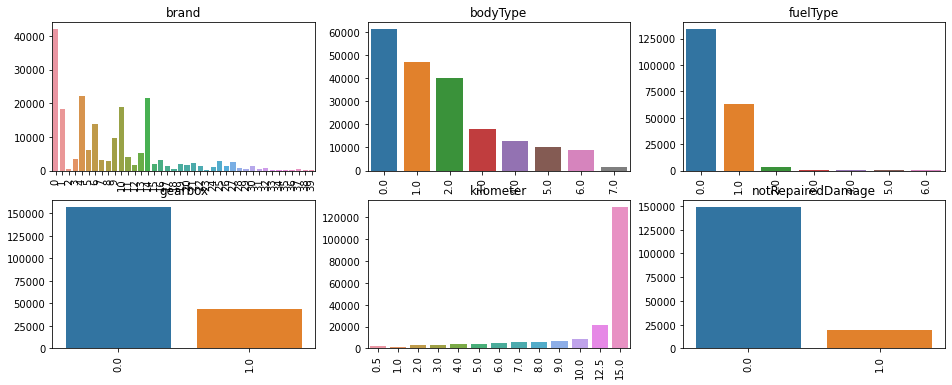

In [325]:
plt.figure(figsize=(16,6))
i = 1
for fea in cat_fea2:
    if all_data[fea].nunique()<50:
        plt.subplot(2,3,i)
        i += 1
        v = all_data[fea].value_counts()
        fig = sns.barplot(x=v.index,y=v.values)
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(fea)
plt.show()

In [326]:
num_fea = ['power','price','v_0','v_1','v_2','v_3','v_4','v_5',
           'v_6','v_7','v_8','v_9','v_10','v_11','v_12','v_13','v_14']

In [327]:
f = pd.melt(all_data,value_vars = num_fea)

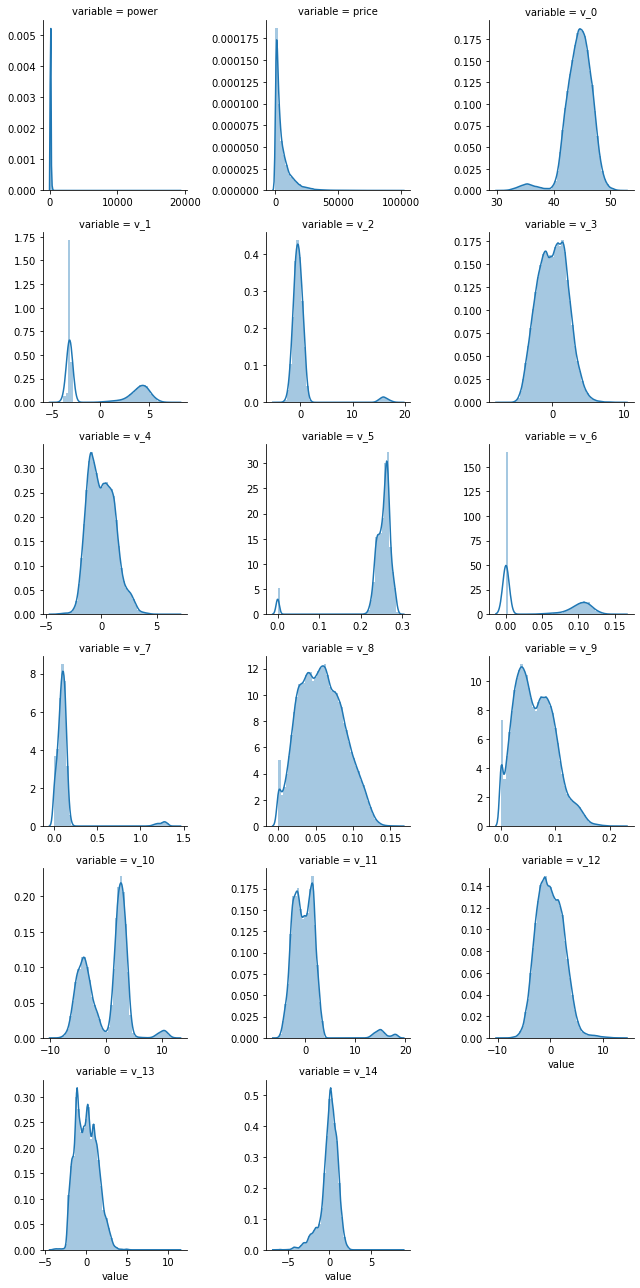

In [330]:
g = sns.FacetGrid(f,col="variable",col_wrap=3,sharex=False,sharey=False)
g = g.map(sns.distplot,'value')

In [333]:
all_data['power'] = all_data['power'].map(lambda x:600 if x>600 else x)

In [339]:
all_data['regDate']

0         20040402
1         20030301
2         20040403
3         19960908
4         20120103
            ...   
199995    20041005
199996    20130409
199997    20041211
199998    20020702
199999    20090708
Name: regDate, Length: 199999, dtype: int64

In [351]:
def date_process(x):
    year = int(str(x)[:4])
    month = int(str(x)[4:6])
    day = int(str(x)[6:8])
    
    if month < 1:
        month = 1
        
    date = datetime(year,month,day)
    return date

In [354]:
all_data['regDate'] = all_data['regDate'].apply(date_process)
all_data['creatDate'] = all_data['creatDate'].apply(date_process)

In [362]:
all_data['regDate_year'] = all_data['regDate'].dt.year
all_data['regDate_month'] = all_data['regDate'].dt.month
all_data['regDate_day'] = all_data['regDate'].dt.day
all_data['creatDate_year'] = all_data['creatDate'].dt.year
all_data['creatDate_month'] = all_data['creatDate'].dt.month
all_data['creatDate_day'] = all_data['creatDate'].dt.day
all_data['car_age_day'] = (all_data['creatDate'] - all_data['regDate']).dt.days

In [366]:
all_data['car_age_year'] = round(all_data['car_age_day'] / 365 , 1)

In [368]:
all_data['regionCode_count'] = all_data.groupby(['regionCode'])['SaleID'].transform('count')
all_data['city'] = all_data['regionCode'].apply(lambda x:str(x)[:2])

In [372]:
all_data.tail()

,SaleID,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,...,regDate_year,regDate_month,regDate_day,creatDate_year,creatDate_month,creatDate_day,car_age_day,car_age_year,regionCode_count,city
199995,249995,2004-10-05,4.0,4,0.0,0.0,1.0,150,15.0,NaN,...,2004,10,5,2016,3,9,4173,11.4,46,55
199996,249996,2013-04-09,65.0,1,0.0,0.0,0.0,179,4.0,0.0,...,2013,4,9,2016,3,23,1079,3.0,65,52
199997,249997,2004-12-11,4.0,4,0.0,0.0,1.0,147,12.5,0.0,...,2004,12,11,2016,3,16,4113,11.3,20,37
199998,249998,2002-07-02,40.0,1,4.0,0.0,1.0,176,15.0,0.0,...,2002,7,2,2016,3,27,5017,13.7,94,61
199999,249999,2009-07-08,32.0,8,1.0,0.0,0.0,0,3.0,0.0,...,2009,7,8,2016,4,1,2459,6.7,18,41


In [376]:
bin = [i*10 for i in range(31)]
all_data['power_bin'] = pd.cut(all_data['power'],bin,labels=False)

In [391]:
cat_cols = ['brand','model','kilometer','fuelType','bodyType']

In [392]:
for col in cat_cols:
    t = train_data.groupby(col,as_index=False)['price'].agg(
        {col+'_count':'count',col+'_price_max':'max',col+'_price_median':'median',
         col+'_price_min':'min',col+'_price_sum':'sum',col+'_price_std':'std',col+'_price_mean':'mean'})
    all_data = pd.merge(all_data,t,on=col,how='left')

<AxesSubplot:>

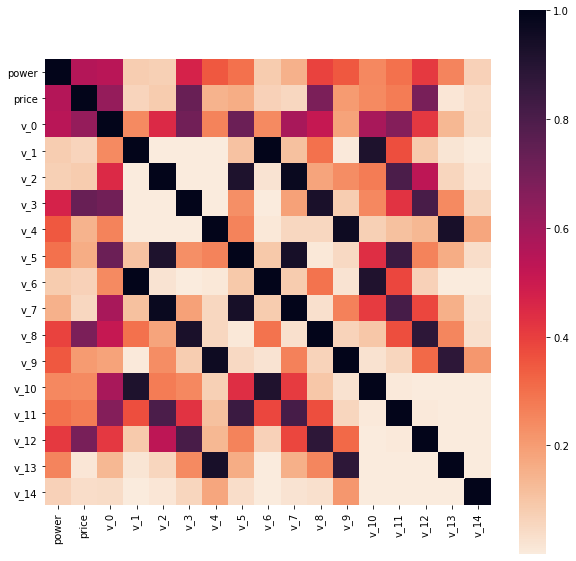

In [408]:
corr1 = abs(all_data[all_data['price'].notnull()][num_fea].corr())
plt.figure(figsize=(10,10))
sns.heatmap(corr1,square=True,cmap=sns.cm.rocket_r)

In [409]:
#power,v0,v3,v8,v12

In [410]:
cross_cols = ['power','v_0','v_3','v_8','v_12']

In [411]:
for i in cross_cols:
    for j in cross_cols:
        all_data['new'+i+"*"+j] = all_data[i] * all_data[j]

(array([1.23906e+05, 1.89270e+04, 4.91800e+03, 1.34000e+03, 4.71000e+02,
        1.88000e+02, 1.24000e+02, 6.00000e+01, 4.80000e+01, 1.80000e+01]),
 array([1.10000e+01, 1.00098e+04, 2.00086e+04, 3.00074e+04, 4.00062e+04,
        5.00050e+04, 6.00038e+04, 7.00026e+04, 8.00014e+04, 9.00002e+04,
        9.99990e+04]),
 <BarContainer object of 10 artists>)

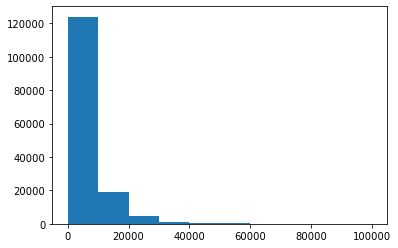

In [413]:
plt.hist(train_data['price'])

(array([   56.,   250.,  1548.,  6206., 22641., 36354., 39259., 31885.,
        10903.,   898.]),
 array([ 2.48490665,  3.38770853,  4.29051041,  5.19331229,  6.09611418,
         6.99891606,  7.90171794,  8.80451982,  9.7073217 , 10.61012358,
        11.51292546]),
 <BarContainer object of 10 artists>)

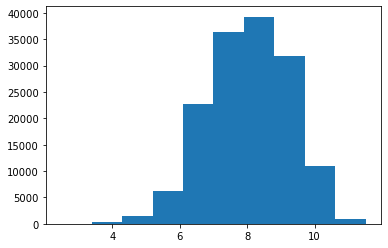

In [414]:
plt.hist(np.log1p(train_data['price']))

In [441]:
all_data['city'] = all_data['city'].astype('int')

In [442]:
df = all_data.copy()

In [443]:
test = df[df['price'].isnull()]
X_train = df[df['price'].notnull()].drop(['price','regDate','creatDate','SaleID','regionCode'],axis=1)
X_test = df[df['price'].isnull()].drop(['price','regDate','creatDate','SaleID','regionCode'],axis=1)
y_train = np.log1p(df[df['price'].notnull()]['price'])

In [446]:
y_train

0         7.523481
1         8.188967
2         8.736007
3         7.783641
4         8.556606
            ...   
149994    8.682877
149995    9.159152
149996    8.922792
149997    8.517193
149998    8.455531
Name: price, Length: 149999, dtype: float64

In [423]:
X_train.shape

(149999, 130)

In [467]:
clf = LGBMRegressor(n_estimators=10000
                   ,learning_rate=0.2
                   ,boosting_type='gbdt'
                   ,objective='regression_l1'
                   ,max_depth=-1
                   ,num_leaves=30
                   ,min_child_samples=20
                   ,feature_fraction=0.8
                   ,lambda_l2=2 
                   ,metric='mae'
                   ,random_state=717)

In [468]:
folds = KFold(n_splits=5,shuffle=True,random_state=717)
mae = 0
oof = np.zeros(X_train.shape[0])
sub = test[['SaleID']].copy()
sub['price'] = 0

In [469]:
for i,(train_idx,val_idx) in enumerate(folds.split(X_train,y_train)):
    train_X,train_y = X_train.iloc[train_idx].reset_index(drop=True),y_train[train_idx]
    val_X,val_y = X_train.iloc[val_idx].reset_index(drop=True),y_train[val_idx]
    clf.fit(train_X,train_y
           ,eval_set=[(val_X,val_y)]
           ,eval_metric='mae'
           ,early_stopping_rounds=100
           ,verbose=0
           )
    sub['price'] = sub['price'] + np.expm1(clf.predict(X_test))/folds.n_splits
    oof[val_idx] = clf.predict(val_X)
    print('val_mae:',mean_absolute_error(np.expm1(val_y),np.expm1(oof[val_idx])))
    mae = mae + mean_absolute_error(np.expm1(val_y),np.expm1(oof[val_idx]))/folds.n_splits

val_mae: 512.2165022648489
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
val_mae: 508.0321471431761
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
val_mae: 526.1276459086737
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
val_mae: 506.09981558858465
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_

In [475]:
sub.to_csv('submit.csv',index=False)

In [ ]:
#下面代码本机跑速度过慢

In [453]:
import hyperopt
from hyperopt import hp,fmin,tpe,Trials,partial
from hyperopt.early_stop import no_progress_loss

In [470]:
def hyperopt_objective(params):
    reg = LGBMRegressor(objective = 'regression_l1',
                        n_estimators = int(params['n_estimators']),
                        num_leaves = int(params['num_leaves']),
                        max_depth = int(params['max_depth']),
                        subsample = params['subsample'],
                        min_child_samples = int(params['min_child_samples'])   
                       )
    val = cross_val_score(reg,
                          X_train,
                          y_train,
                          verbose=0,
                          cv=5,
                          scoring=make_scorer(mean_absolute_error)
                         ).mean()
    return val

In [471]:
param_simple = {
                'n_estimators': hp.quniform('n_estimators',200,10000,1),
                'num_leaves': hp.quniform('num_leaves',2,100,1),
                'max_depth': hp.quniform('max_depth',2,100,1),
                'subsample': hp.uniform('subsample',0.1,1),
                'min_child_samples': hp.quniform('min_child_samples',2,100,1)
               }

In [472]:
def param_hyperopt(max_evals=100):
    trials = Trials()
    early_stop_fn = no_progress_loss(100)
    
    params_best = fmin(hyperopt_objective,
                       space = param_simple,
                       algo = tpe.suggest,
                       max_evals = max_evals,
                       verbose = True,
                       trials = trials,
                       early_stop_fn = early_stop_fn
                      )
    print('\n','\n','best params:',params_best,'\n')
    return params_best,trials

In [473]:
params_best , trials = param_hyperopt(30)

 27%|███████████▋                                | 8/30 [1:55:03<5:16:25, 862.99s/trial, best loss: 0.1130711638877095]


KeyboardInterrupt: 